In [1]:
import os
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from python.data import Dataloader
from python.models import RandomExampleModel
from python.metrics import PairsExplained, ClusterIntersection

In [3]:
# Loading the data
data_loader = Dataloader("../data/dataset_10") # Specify path to the dataset you want to load
X, Y = data_loader.load()
Z = data_loader.get_ground_truth_labels()
print(X.shape)
print(Y.shape)
print(Z.shape)

(40002, 10)
(40002, 10)
(40002,)


In [4]:
# Let's train an example model
model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data
print(X.shape)

(40002, 10)


In [5]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.0172     -0.17280946]
 [ 0.1904899   0.05389895]
 [-0.18002516 -0.11719372]
 [ 0.24068762  0.22920997]
 [ 0.14951786  0.09248784]]


In [6]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]]


In [7]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 0.4


In [8]:
# Or we call directly the right metric:
pairs_explained = PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.6719664016799161
Percentage of explained preferences for all samples: 0.6719664016799161


In [9]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[0 0 1 0 0]


In [10]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
# We can see how it compares to our model's predictions:
print(Z[:5])

[1 0 2 1 0]


In [11]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.5236179280008775
Cluster intersection for all samples: 0.5236179280008775


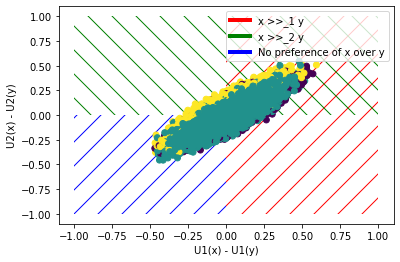

In [12]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

In [13]:
from python.models import HeuristicModel

# matrix_results = []
# for cluster in range(2, 10):
#     list_temp = []
#     for l in range(5, 10):
#         model = HeuristicModel(n_clusters=cluster, n_pieces=l, nb_iterations=5)
#         model.fit(X[:200], Y[:200])
#         list_temp.append([pairs_explained.from_model(model, X, Y), cluster_intersection.from_model(model, X, Y, Z)])
#     matrix_results.append(list_temp)
# print(matrix_results)

# l = 5
# matrix_results = []
# for cluster in range(3, 10):
#     model = HeuristicModel(n_clusters=cluster, n_pieces=l, nb_iterations=5)
#     model.fit(X, Y)
#     matrix_results.append([pairs_explained.from_model(model, X, Y), cluster_intersection.from_model(model, X, Y, Z)])
# print(matrix_results)

import time
start_time = time.time()
model = HeuristicModel(n_clusters=3, n_pieces=5, nb_iterations=5)
model.fit(X, Y)
end_time = time.time()

# print(model.list_results)
# Uncomment once your model is working
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-11
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 979 rows, 1573 columns and 23520 nonzeros
Model fingerprint: 0x6ad283dd
Variable types: 976 continuous, 597 integer (597 binary)
Coefficient statistics:
  Matrix range     [3e-05, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 11.3687229
Presolve removed 60 rows and 627 columns
Presolve time: 0.04s
Presolved: 919 rows, 946 columns, 19413 nonzeros
Found heuristic solution: objective 7.2949598
Variable types: 349 continuous, 597 integer (597 binary)

Root relaxation: objective 0.000000e+00, 392 iterations, 0.00 seconds (0.00 work units)

 

  0%|          | 0/5 [00:00<?, ?it/s]

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 15508 rows, 61848 columns and 568049 nonzeros
Model fingerprint: 0xecd85fac
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+00]
Presolve removed 20 rows and 46351 columns
Presolve time: 0.66s
Presolved: 50 rows, 15538 columns, 449842 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 1
 AA' NZ     : 1.225e+03
 Factor NZ  : 1.275e+03 (roughly 6 MB of memory)
 Factor Ops : 4.293e+04 (less than 1 second per iteration)
 Threads    : 3

                

 20%|██        | 1/5 [00:38<02:34, 38.52s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30722 rows, 122520 columns and 1124945 nonzeros
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+00]
LP warm-start: use basis
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.515300e+00   0.000000e+00      0s
    1587    1.4138521e+01   0.000000e+00   0.000000e+00      5s

Solved in 1587 iterations and 4.74 seconds (5.68 work units)
Optimal objective  1.413852123e+01
--- Solution found ---
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 ph

 40%|████      | 2/5 [01:27<02:13, 44.58s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 45791 rows, 182612 columns and 1676432 nonzeros
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+00]
LP warm-start: use basis
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.500800e+00   0.000000e+00      0s
    2300    1.0697581e+01   7.248359e+00   0.000000e+00      5s
    2596    1.0960910e+01   0.000000e+00   0.000000e+00      6s

Solved in 2596 iterations and 6.16 seconds (9.32 work units)
Optimal objective  1.096090989e+01
--- Solution found ---
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ C

 60%|██████    | 3/5 [02:12<01:29, 44.74s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60875 rows, 242764 columns and 2228465 nonzeros
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+00]
LP warm-start: use basis
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.502300e+00   0.000000e+00      0s
    2002    1.0288911e+01   0.000000e+00   0.000000e+00      5s

Solved in 2002 iterations and 5.09 seconds (7.49 work units)
Optimal objective  1.028891087e+01
--- Solution found ---
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 ph

 80%|████████  | 4/5 [02:56<00:44, 44.57s/it]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 75904 rows, 302696 columns and 2778438 nonzeros
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 1e+00]
LP warm-start: use basis
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.496800e+00   0.000000e+00      0s
    1948    9.3333124e+00   0.000000e+00   0.000000e+00      5s

Solved in 1948 iterations and 5.38 seconds (7.77 work units)
Optimal objective  9.333312409e+00
--- Solution found ---
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19044.2))

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 ph

100%|██████████| 5/5 [03:59<00:00, 47.98s/it]


Percentage of explained preferences on train data: 0.9671016449177541
Percentage of preferences well regrouped into clusters: 0.6697555674952433


In [14]:
print(end_time-start_time)

608.9494836330414


In [15]:
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))

Percentage of explained preferences on train data: 0.9671016449177541
Percentage of preferences well regrouped into clusters: 0.6697555674952433


In [16]:
for cluster in range(3):
    print(len(model.models[cluster].delta_j_k))

AttributeError: 'OneClusterMIP' object has no attribute 'delta_j_k'

In [ ]:
# Pour les itérations qui vont de 1 jusqu'à 14
list_temp = [[0.6502674866256687, 0.566093804757026], [0.8708314584270787, 0.5736255498667281], [0.9052297385130743, 0.578316193062625], [0.9215039248037599, 0.5813184478897602], [0.9264286785660717, 0.5828593323215018], [0.9293785310734464, 0.5856833005203569], [0.9298285085745712, 0.588556312540864], [0.9331033448327584, 0.5913835854918587], [0.9350532473376331, 0.5934690615785453], [0.9364281785910704, 0.5956767060024539], [0.9371031448427578, 0.5979485181137059], [0.9385530723463826, 0.5999390613204771], [0.9402529873506325, 0.6024372077063755], [0.9411529423528824, 0.6052946546442833], [0.9428278586070696, 0.6072679116475416]] # en 25 min, k = 3, l = 5

list_temp_new_init = [[0.9174291285435728, 0.5908782233946476], [0.9348032598370082, 0.6038163605181907], [0.9463276836158192, 0.6137585798393138], [0.9527023648817559, 0.6204919873253356], [0.9550522473876306, 0.6254821680555431], [0.9566521673916304, 0.6287092285219743], [0.9574021298935054, 0.6309042763906404], [0.9576771161441928, 0.6331563999785561], [0.9582020898955053, 0.6351262122401742], [0.9587520623968802, 0.6369728537397534], [0.9590520473976302, 0.6386921597896505], [0.9596020198990051, 0.6399426709997467], [0.9600269986500675, 0.6407216750734674], [0.96045197740113, 0.6414457132696977], [0.9611269436528174, 0.6422581523357521]] # en 27 min
# init avec (la classe) twocluster sur 200 ex, k=3, l=5

list_temp_new_init_several_clusters = [[0.9065046747662617, 0.5836271472344234], [0.912104394780261, 0.5891387126101308], [0.9177541122943853, 0.5940250136314463], [0.9227538623068846, 0.5994042964285125], [0.9274536273186341, 0.6046678266571659], [0.9326533673316334, 0.6097296370150618], [0.9373281335933203, 0.6149354690711504], [0.9419029048547573, 0.6187817280969156], [0.9461276936153192, 0.6214538689330127], [0.9486275686215689, 0.6244430484908093], [0.9510274486275686, 0.6265792007767177], [0.9526273686315684, 0.6286510303869072], [0.9531773411329434, 0.6302354665522143], [0.9551772411379431, 0.6317884400772587], [0.955527223638818, 0.6333770159320838]] # en 30 min
# init avec (la classe) twocluster sur 200 ex, k=3, l=5 en autorisant qu'un pt appartienne à plusieurs clusters

# Pour k et l qui variaient entre 2 et 9, et 5 et 9. (sur 5 iter)
matrix_results_temp = [[[0.8316334183290836, 0.5515081362003998], [0.8323083845807709, 0.5097614285056603], [0.8191590420478976, 0.5096678655230009], [0.8021098945052747, 0.5070037253368451], [0.8263586820658967, 0.515264555764237]], [[0.8820808959552022, 0.579856727520615], [0.8862056897155143, 0.5615577149694302], [0.8848307584620769, 0.5740439759842462], [0.9052047397630119, 0.5619870952653713], [0.9033298335083246, 0.5652114509346656]], [[0.9286285685715714, 0.5881918386268632], [0.9214039298035098, 0.5933340717029547], [0.9356282185890705, 0.5870495130527091], [0.9171041447927604, 0.5975502042377444], [0.903904804759762, 0.596889847515324]], [[0.9388780560971951, 0.6124469494632315], [0.9491025448727564, 0.5991719926015899], [0.9285285735713215, 0.6036116008754199], [0.9407279636018199, 0.6079771309552069], [0.9375781210939453, 0.6121938596952805]], [[0.9533523323833808, 0.6107819568397596], [0.9650517474126293, 0.620176063520016], [0.9670516474176292, 0.6134396600086998], [0.9653767311634418, 0.6171800094778142], [0.9633518324083796, 0.6260746161211976]], [[0.9530273486325683, 0.6287490217874296], [0.9647017649117544, 0.6478451870511647], [0.9614019299035048, 0.626767210425759], [0.9756512174391281, 0.6234982331031445], [0.9433778311084445, 0.6265004579325295]], [[0.9712264386780661, 0.6360144056245601], [0.9697265136743163, 0.6237766434720188], [0.9664516774161291, 0.6312091472749429], [0.964176791160442, 0.626228622070559], [0.9699015049247538, 0.6295294732525942]], [[0.9747262636868157, 0.627525872275172], [0.97977601119944, 0.6356242886338221], [0.9779011049447528, 0.6294262397452363], [0.9825508724563772, 0.6427337216674578], [0.97997600119994, 0.6194931934861221]]] # en 20 min

# l = 5, k variant de 3 à 9
list_new_init_2 = [[0.9550522473876306, 0.6254821680555431], [0.9779761011949403, 0.6242548101089234], [0.983950802459877, 0.6094660017880333], [0.991700414979251, 0.6159219888309352], [0.9986750662466877, 0.6615412248312111], [0.9995750212489376, 0.6706278520728097], [0.9980000999950003, 0.6277113933608587]] # en 40 min sur tout le dataset
matrix_temp_2 = []
for cluster in range(len(matrix_results_temp)):
    list_temp = []
    for l in range(len(matrix_results_temp[0])):
        list_temp.append(matrix_results_temp[cluster][l][0]+matrix_results_temp[cluster][l][1])
    matrix_temp_2.append(list_temp)
matrix_temp_2 = np.array(matrix_temp_2)
print(matrix_temp_2)
print(np.argmax(matrix_temp_2)) # l = 8 et k = 9

# c'est normal que la précision augmente avec L parce que le modèle est plus flexible mais du coup on va fixer L
# on va augmenter le nombre de clusters (pour tester si ça marche tjs)
# on va augmenter le nombre de données à prendre en compte

[[1.38314155 1.34206981 1.32882691 1.30911362 1.34162324]
 [1.46193762 1.4477634  1.45887473 1.46719184 1.46854128]
 [1.51682041 1.514738   1.52267773 1.51465435 1.50079465]
 [1.55132501 1.54827454 1.53214017 1.54870509 1.54977198]
 [1.56413429 1.58522781 1.58049131 1.58255674 1.58942645]
 [1.58177637 1.61254695 1.58816914 1.59914945 1.56987829]
 [1.60724084 1.59350316 1.59766082 1.59040541 1.59943098]
 [1.60225214 1.6154003  1.60732734 1.62528459 1.59946919]]
38
